In [6]:
# Load pickled data
import pandas as pd
import pickle

training_file = './train.p'
validation_file = './valid.p'
testing_file = './test.p'
#generated_file = './generated.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

assert(len(X_train) == len(y_train))
assert(len(X_valid) == len(y_valid))
assert(len(X_test) == len(y_test))

sign_names = pd.read_csv('./signnames.csv')

n_train = len(X_train)
n_test = len(X_test)
n_valid = len(X_valid)

image_shape = X_train.shape[1:]
n_classes = sign_names.shape[0]

total = len(X_train) + len(X_valid) + len(X_test)

print('Total dataset:', total)
print("Number of training examples = {} ({:.2f}% of total)".format(n_train, 100 * len(X_train) / total))
print("Number of validation examples = {} ({:.2f}% of total)".format(n_valid, 100 * len(X_valid) / total))
print("Number of testing examples = {} ({:.2f}% of total)".format(n_test, 100 * len(X_test) / total))
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)


Total dataset: 51839
Number of training examples = 34799 (67.13% of total)
Number of validation examples = 4410 (8.51% of total)
Number of testing examples = 12630 (24.36% of total)
Image data shape = (32, 32, 3)
Number of classes = 43


In [31]:
import numpy as np
import matplotlib.pyplot as plt

generated_file = './generated.p'
with open(generated_file, mode='rb') as f:
    generated = pickle.load(f)
    
X_generated, y_generated = generated['features'], generated['labels']

print('Generated data loaded', X_generated.shape, y_generated.squeeze().shape, y_train.shape)

X_train_comb = np.vstack((X_train, X_generated))
y_train_comb = np.append(y_train, y_generated.squeeze())

print(X_train_comb.shape, y_train_comb.shape)

c, b = np.histogram(y_train, range(n_classes))

print('Unque:', np.unique(y_train, return_counts=True))
print(c.shape, b.shape)


plt.figure()
plt.bar(b, c)
plt.show()

Generated data loaded (49981, 32, 32, 3) (49981,) (34799,)
(84780, 32, 32, 3) (84780,)
Unque: (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42], dtype=uint8), array([ 180, 1980, 2010, 1260, 1770, 1650,  360, 1290, 1260, 1320, 1800,
       1170, 1890, 1920,  690,  540,  360,  990, 1080,  180,  300,  270,
        330,  450,  240, 1350,  540,  210,  480,  240,  390,  690,  210,
        599,  360, 1080,  330,  180, 1860,  270,  300,  210,  210]))
(42,) (43,)


ValueError: incompatible sizes: argument 'height' must be length 43 or scalar

In [ ]:
import matplotlib.pyplot as plt

image_index = np.random.randint(len(X_generated))

image = X_generated[image_index]
sign_index = y_generated[image_index]

print(sign_names.SignName[sign_index])
print(image.shape)
plt.imshow(image)
plt.show()


In [7]:
def increase_brightness(image):
#     image_y = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
#     image_y[:,:,0] += 25;
#     return cv2.cvtColor(image_y, cv2.COLOR_YCrCb2RGB)
    #print('increase brightness')
    maxIntensity = 255.0

    # Parameters for manipulating image data
    phi = 1
    theta = 1

    # Increase intensity such that
    # dark pixels become much brighter, 
    # bright pixels become slightly bright
    bright = (maxIntensity/phi)*(image/(maxIntensity/theta))**0.5
    bright = np.array(bright, dtype = np.uint8)
    return bright

def decrease_brightness(image):
    maxIntensity = 255.0

    # Parameters for manipulating image data
    phi = 1
    theta = 1
    
    # Decrease intensity such that
    # dark pixels become much darker, 
    # bright pixels become slightly dark 
    dark = (maxIntensity/phi)*(image/(maxIntensity/theta))**2
    dark = np.array(dark, dtype = np.uint8)

    return dark

def rotate_image(img, degreesCCW = 30, scaleFactor = 1):
    # mostly copied from http://stackoverflow.com/questions/11764575/
    #print('rotating image', scaleFactor, degreesCCW)
    (oldY,oldX) = img.shape[0], img.shape[1] #note: numpy uses (y,x) convention but most OpenCV functions use (x,y)
    M = cv2.getRotationMatrix2D(center=(oldX/2,oldY/2), angle=degreesCCW, scale=scaleFactor) #rotate about center of image.

    #choose a new image size.
    newX,newY = oldX*scaleFactor,oldY*scaleFactor
    #include this if you want to prevent corners being cut off
    r = np.deg2rad(degreesCCW)
    newX,newY = (abs(np.sin(r)*newY) + abs(np.cos(r)*newX),abs(np.sin(r)*newX) + abs(np.cos(r)*newY))

    #the warpAffine function call, below, basically works like this:
    # 1. apply the M transformation on each pixel of the original image
    # 2. save everything that falls within the upper-left "dsize" portion of the resulting image.

    #So I will find the translation that moves the result to the center of that region.
    (tx,ty) = ((newX-oldX)/2,(newY-oldY)/2)
    M[0,2] += tx #third column of matrix holds translation, which takes effect after rotation.
    M[1,2] += ty

    rotatedImg = cv2.warpAffine(img, M, dsize=(int(newX),int(newY)))
    
    diff = (np.array([rotatedImg.shape[0] - image.shape[0], rotatedImg.shape[1] - image.shape[1]]) / 2).astype(np.uint8)
    #print('Rotated shape: {} Diff: {}'.format(rotatedImg.shape, diff))
    rot_scaled_image = rotatedImg[diff[0]: diff[0] + 32, diff[1]: diff[1] + 32]

    return rot_scaled_image

def shift(images, dx):
    return np.roll(images, dx, axis=1)

def add_noise(image, noise_factor=30):
    noise = np.random.randint(0,noise_factor,image.shape).astype(np.uint8)
    image_noise = cv2.add(image, noise)
    return image_noise

def pca(image):
    # mean center image
    X = np.mean(image, 2)
    X -= np.mean(X, axis=0)
    cov = np.dot(X, X.T) / X.shape[0]
    U,S,V = np.linalg.svd(cov)
    Xrot = np.dot(X, U)
    Xwhite = Xrot / np.sqrt(S + 1e-5)
    print(Xwhite.shape)
    return Xwhite.astype(np.uint8)

def zca_whitening(inputs):
    sigma = np.dot(inputs, inputs.T)/inputs.shape[1] #Correlation matrix
    U,S,V = np.linalg.svd(sigma) #Singular Value Decomposition
    epsilon = 0.1                #Whitening constant, it prevents division by zero
    ZCAMatrix = np.dot(np.dot(U, np.diag(1.0/np.sqrt(np.diag(S) + epsilon))), U.T) #ZCA Whitening matrix
    return np.dot(ZCAMatrix, inputs)   #Data whitening

def scale_image(image, size):
    image_s = cv2.resize(image, (size, size), interpolation = cv2.INTER_CUBIC)
    
    if size < image.shape[0]:
        # we need to pad
        diff = (np.array([image.shape[0] - size, image.shape[1] - size]) / 2).astype(np.uint8)
        bg = np.pad(image_s, (diff, diff, (0,0)), 'constant')
        assert(bg.shape[0] == 32 and bg.shape[1] == 32)
    else:
        # we need to just get 32 x 32
        #print('bigger image we need a smaller one')
        start = int((size - image.shape[0]) / 2)
        bg = image_s[start: start + 32, start: start + 32]
    return bg

# image = X_train[0]
# image_s = scale_image(image, 40)
# print(image_s.shape)
# plt.figure()
# plt.subplot(1,2,1)
# plt.imshow(image)
# plt.subplot(1,2,2)
# plt.imshow(image_s)
# plt.show()

In [35]:
import numpy as np
import cv2
import os

print('classes', n_classes)
print(range(n_classes))

bins, classes_hist = np.unique(y_train, return_counts=True)
classes_hist = np.array(list(zip(bins,classes_hist)))
highest = np.max(classes_hist[:,1])

# we would like to have a more uniform distribution of data
ops = [lambda image: increase_brightness(scale_image(image, 36)), 
       lambda image: decrease_brightness(scale_image(image, 36)),
       lambda image: rotate_image(image, angle), 
       lambda image: rotate_image(image, -angle),
       lambda image: scale_image(image, 28),
       lambda image: add_noise(image),
       lambda image: shift(image, 2),
       lambda image: shift(image, -2)]

X_generated = np.empty([0,32, 32, 3]).astype(np.uint8)
y_generated = np.empty((0,1)).astype(np.uint8)

for category, count in classes_hist:
    folder = './gen_images/{}'.format(category)
    if not os.path.exists(folder):
        os.makedirs(folder)
    
    #print('Creating X_generated for the category')
    short = highest - count
    # we have 5 ways to generate more images from a given one
    # so max we can generate would be 
    possible = count * len(ops)
    required = min(possible, short)
    
    print("Generating {} for class {}".format(required, category))
    
    if required > 0:
        order = np.random.choice(count, required)
        image_index = np.where(y_train == category)
        image_index = image_index[0]
        
        #print(np.max(order), len(image_index))
        op_index = 0
        
        for i in order:
            index = image_index[i]
            #print('Using image', index)
            image = np.copy(X_train[index])

            #print(index, op_index)
            image_generated = ops[op_index](image)
            
            file_name = '{}/{}.jpg'.format(folder, index)
            cv2.imwrite(file_name, image_generated)
            #file_org = '{}/{}-org.jpg'.format(folder, index)
            #cv2.imwrite(file_org, X_train[index])

            X_generated = np.vstack((X_generated, [image_generated]))
            y_generated = np.vstack((y_generated, [category]))
            
            angle = 10 + np.random.randint(10, size=1)
            
            op_index += 1
            if op_index >= len(ops):
                op_index = 0
    
with open('./generated.p'.format(category), 'wb') as f:
    pickle.dump({'features':X_generated, 'labels': y_generated}, f)
    print('Saved generated data in generated.p')
    print('Images Shape:', X_generated.shape)
    print('Labels Shape:', y_generated.shape)

classes 43
range(0, 43)
Generating 1440 for class 0
Generating 30 for class 1
Generating 0 for class 2
Generating 750 for class 3
Generating 240 for class 4
Generating 360 for class 5
Generating 1650 for class 6
Generating 720 for class 7
Generating 750 for class 8
Generating 690 for class 9
Generating 210 for class 10
Generating 840 for class 11
Generating 120 for class 12
Generating 90 for class 13
Generating 1320 for class 14
Generating 1470 for class 15
Generating 1650 for class 16
Generating 1020 for class 17
Generating 930 for class 18
Generating 1440 for class 19
Generating 1710 for class 20
Generating 1740 for class 21
Generating 1680 for class 22
Generating 1560 for class 23
Generating 1770 for class 24
Generating 660 for class 25
Generating 1470 for class 26
Generating 1680 for class 27
Generating 1530 for class 28
Generating 1770 for class 29
Generating 1620 for class 30
Generating 1320 for class 31
Generating 1680 for class 32
Generating 1411 for class 33
Generating 1650 fo

In [49]:
count, bins = np.histogram(y_generated, np.arange(n_classes))
print(bins)
print(np.unique(y_generated))
# print(list(zip(bins, count)))
# print(count.shape, bins.shape)


# plt.figure()
# plt.bar(bins, count)
# plt.show()

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42]
[ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42]


In [8]:
import numpy as np

classes_hist, bins = np.histogram(y_train, bins=range(n_classes + 1))
classes_hist = np.array(list(zip(bins,classes_hist)))
highest = np.max(classes_hist[:,1])
print(highest)

2010


In [ ]:
X_generated = np.empty([0,32, 32, 3]).astype(np.uint8)
y_generated = np.empty(0).astype(np.uint8)


print(X_generated.shape, y_generated.shape)

206


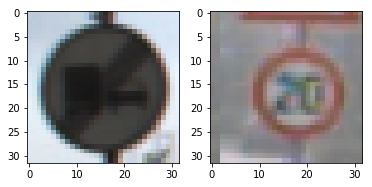

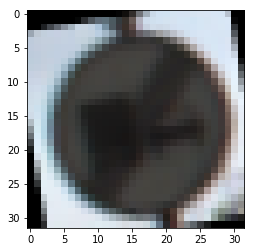

In [36]:
import matplotlib.pyplot as plt

%matplotlib inline

category = 42
index = 9956

# find out where would this image exists in this category so that 
# we can read it from the X_generated array

image_index = np.where(y_train == category)[0]
org_index = np.where(image_index == index)[0][0]
print(org_index)
    
image = X_train[index]
image_op = ops[2](image)
image_g = X_generated[org_index]

plt.figure()
plt.subplot(1,2,1)
plt.imshow(image)
plt.subplot(1,2,2)
plt.imshow(image_g)

plt.figure()
plt.imshow(image_op)
